### Context
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the bank poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help.

 

### Objective
To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

 

### Data Description
The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

### Data Dictionary

- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of Visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

In [1]:
!pip install yellowbrick

In [2]:
# this will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# To supress warnings
import warnings

warnings.filterwarnings("ignore")


<IPython.core.display.Javascript object>

## Loading the Data

In [3]:
data = pd.read_excel("Credit Card Customer Data.xlsx")

<IPython.core.display.Javascript object>

## EDA

In [4]:
data.shape

(660, 7)

<IPython.core.display.Javascript object>

In [5]:
df = data.copy()
df.sample(5)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
467,468,70101,36000,4,4,2,1
201,202,13215,11000,1,0,3,8
570,571,75366,64000,4,2,1,1
435,436,26604,74000,4,5,0,3
532,533,47848,48000,4,3,2,2


<IPython.core.display.Javascript object>

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


<IPython.core.display.Javascript object>

- It appears like there are no missing values in any columns. However, there are some '0' values. They will checked out during the analysis to determine if they are accurate, or they represent missing values.
- All columns are of data type integer.

In [7]:
df.isna().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

<IPython.core.display.Javascript object>

- We can now confirm that there are no actual missing values.

In [8]:
len(df[df.Total_visits_bank == 0])

100

<IPython.core.display.Javascript object>

- There are 100 rows where the column total_vistis_bank are 0. After exploring the rows and columns, it is unlikely that these are missing values since it is plausible that a customer has not visited the physical building of the bank.

In [9]:
len(df[df.Total_visits_online == 0])

144

<IPython.core.display.Javascript object>

In [10]:
(df.Total_calls_made == 0).sum()

97

<IPython.core.display.Javascript object>

In [11]:
df[df.Total_visits_bank | df.Total_visits_online | df.Total_calls_made == 0]

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made


<IPython.core.display.Javascript object>

- There are 144 total visits online and 97 total calls made rows which have a value of 0. These observations are also plausible, therefore these are not missing values.
- Furthermore, there are no customers who have all communication channels as a 0. This could be an indication that the customers go with the options that they are most comfortable with, i.e. physical visits, online visits, or making calls to the bank.

In [12]:
df.duplicated().sum()

0

<IPython.core.display.Javascript object>

- It seems like there are no duplicates in the dataset.

#### Data Pre-processing

It appears that SI_No and Customer Key columns are only used for identification purposes. These will be dropped from the analysis before further EDA to remove unnecessary data.

In [13]:
df.drop("Customer Key", axis=1, inplace=True)
df.drop("Sl_No", axis=1, inplace=True)


<IPython.core.display.Javascript object>

In [14]:
df.describe()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000
mean,34574.242424,4.706061,2.403030,2.606061,3.583333
std,37625.487804,2.167835,1.631813,2.935724,2.865317
min,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,48000.000000,6.000000,4.000000,4.000000,5.000000
max,200000.000000,10.000000,5.000000,15.000000,10.000000


<IPython.core.display.Javascript object>

- The average credit limit is ~34574 with a std dev of ~37625. Additionally, the minimum limit is 3000 and the maximum limit is 200000. These values are indicative of outliers.
- Values for total credit cards seem close to each other, but it is possible the data might be skewed to the right the max values is further from the median, 75% and mean. Total visits online and total calls made also have similar distributions.
- Total visits to the bank seems to be a little bit normally distributed.
- Subsequent plots will help illiminated the distribution in these columns.

In [15]:
# Let's see unique values
cols = df.columns

for col in cols:
    print("Unique values in the column '{}' are \n\n".format(col), df[col].unique())
    print("-" * 100)

Unique values in the column 'Avg_Credit_Limit' are 

 [100000  50000  30000  20000  15000   5000   3000  10000  13000  11000
   9000   6000   8000  19000  16000  18000  17000  14000  12000   7000
  73000  49000  67000  61000  75000  48000  56000  72000  70000  51000
  69000  40000  44000  31000  37000  65000  46000  74000  58000  39000
  52000  33000  47000  71000  41000  59000  64000  45000  54000  66000
  27000  43000  36000  25000  57000  26000  38000  35000  34000  28000
  63000  29000  68000  42000  62000  32000  60000  55000 157000  94000
 163000 131000  96000 136000 121000 158000 108000 166000 176000 178000
  91000 156000 146000  84000 155000 200000 195000 187000 106000 114000
 126000 173000 153000 184000 123000 144000  97000  98000 127000 171000
 186000 183000 111000 112000 132000  95000 172000  99000 145000 167000]
----------------------------------------------------------------------------------------------------
Unique values in the column 'Total_Credit_Cards' are 

 [ 2  3 

<IPython.core.display.Javascript object>

- Apart from the avg credit limit column, all the other columns do not have very many unique values.

## Univariate Analysis

In [16]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

#### Observations on Avg_Credit_Limit

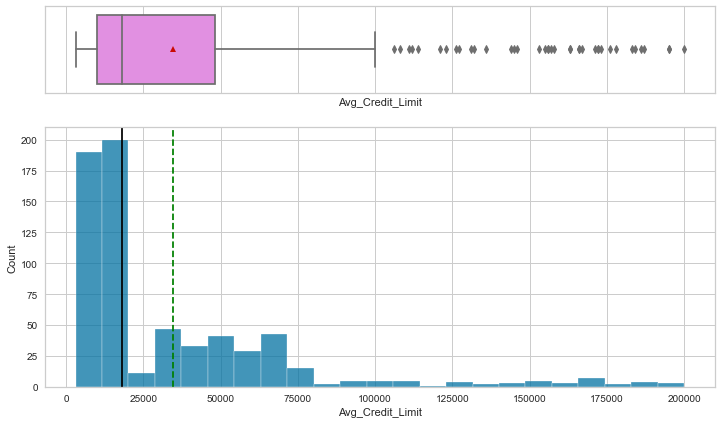

<IPython.core.display.Javascript object>

In [17]:
histogram_boxplot(df, "Avg_Credit_Limit")

- Avg_Credit_Limit has outliers in the upper limits.
- The data is skewed to the right.

In [18]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<IPython.core.display.Javascript object>

#### Observations on Total_Credit_Cards

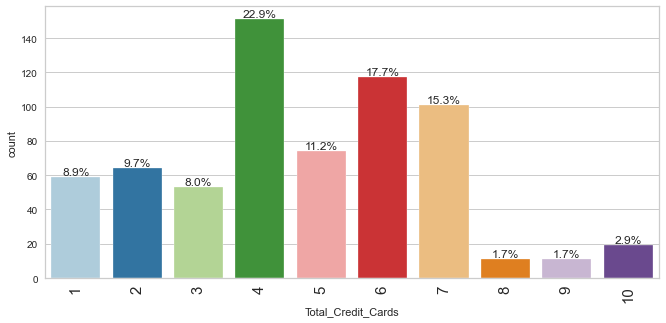

<IPython.core.display.Javascript object>

In [19]:
labeled_barplot(df, "Total_Credit_Cards", perc=True)

- 22.9% of the customers have 4 credit cards. They are closely followed by customers with 6 and 7 credits cards at 17.7% and 15.3% respectively.
- As one would expect, there are fewer people with 8-10 credit cards. 

#### Observations on Total_visits_bank

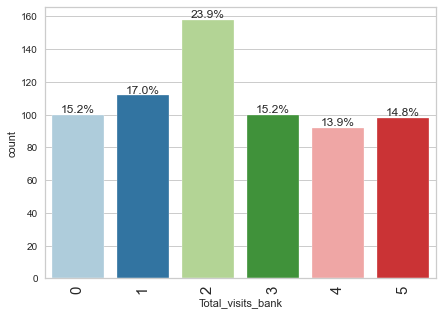

<IPython.core.display.Javascript object>

In [20]:
labeled_barplot(df, "Total_visits_bank", perc=True)

- Majority of customers(23.9%) visited the bank twice. The other total visits are relatively similarly distributed.
- The data is also skewed to the right.

#### Observations on Total_visits_online

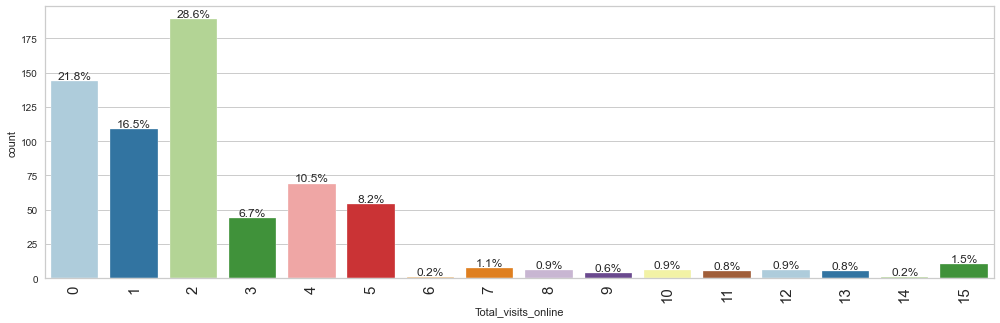

<IPython.core.display.Javascript object>

In [21]:
labeled_barplot(df, "Total_visits_online", perc=True)

- The data is skewed to the right. 
- The majority of the customers (28.6%) visited the bank online. Notably, too, 21.8% of the customers did not visit the bank online. 
- The bank can increase its revenue if they are able to attract more customers online, especially for the customers that are far from the bank.

#### Observations on Total_calls_made

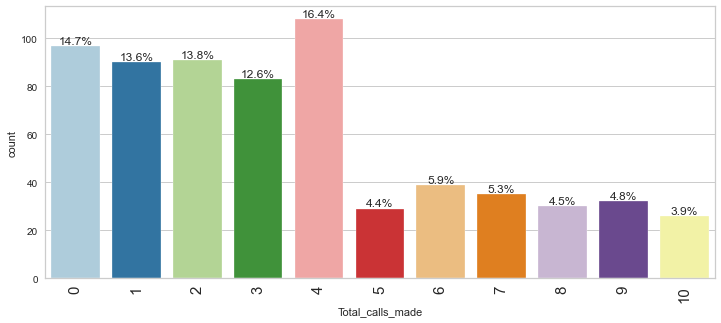

<IPython.core.display.Javascript object>

In [22]:
labeled_barplot(df, "Total_calls_made", perc=True)

- The data is skewed to the right.
- It is interesting to note that most of the customers made 4 or less calls to the bank. If the bank was not able to contribute positively to their revenue through calls, this is an opportunity to increase their outreach and engagement with the customers.
- Additionally, if the few calls are an indication of excellent customer service, they should carry on with those valiant efforts.

In [23]:
# fig, axes = plt.subplots(3, 2, figsize=(20, 15))
# fig.suptitle("CDF plot of columns", fontsize=20)
# counter = 0
# for ii in range(3):
#     sns.ecdfplot(ax=axes[ii][0], x=df[counter])
#     counter = counter + 1
#     if counter != 5:
#         sns.ecdfplot(ax=axes[ii][1], x=df[counter])
#         counter = counter + 1
#     else:
#         pass

# fig.tight_layout(pad=2.0)

<IPython.core.display.Javascript object>

## Bivariate Analysis

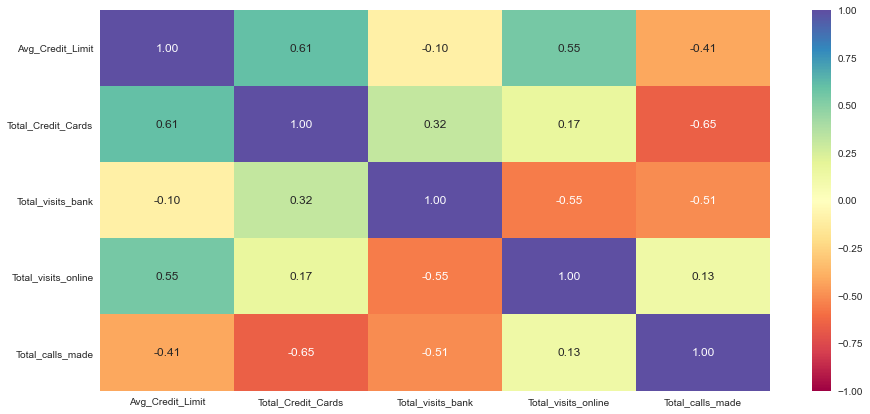

<IPython.core.display.Javascript object>

In [24]:
plt.figure(figsize=(15, 7))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

- There is a strong positive correlation between Avg credit limit and total visits online and total credit cards at 0.55 and 0.61 respectively. 
- There is also a moderate positive correlation between total credit cards are total visits bank at 0.32
- There is a strong negative correlation between total credit cards and total calls made.
- Total visits bank has a strong negative correlation with total calls made and total visits online at 0.51 and 0.55 respectively.
- Additionally, there is a moderate negative correlation between the avg credit limit and the total calls made. 

- In instances of strong positive correlations such as that between the avg credit limit and total visits online and total creedits, the bank should continue naturing those relations to increase their revenue. For instance, for the customers that have proved to be non-defaulters, their credit limits could be increased.

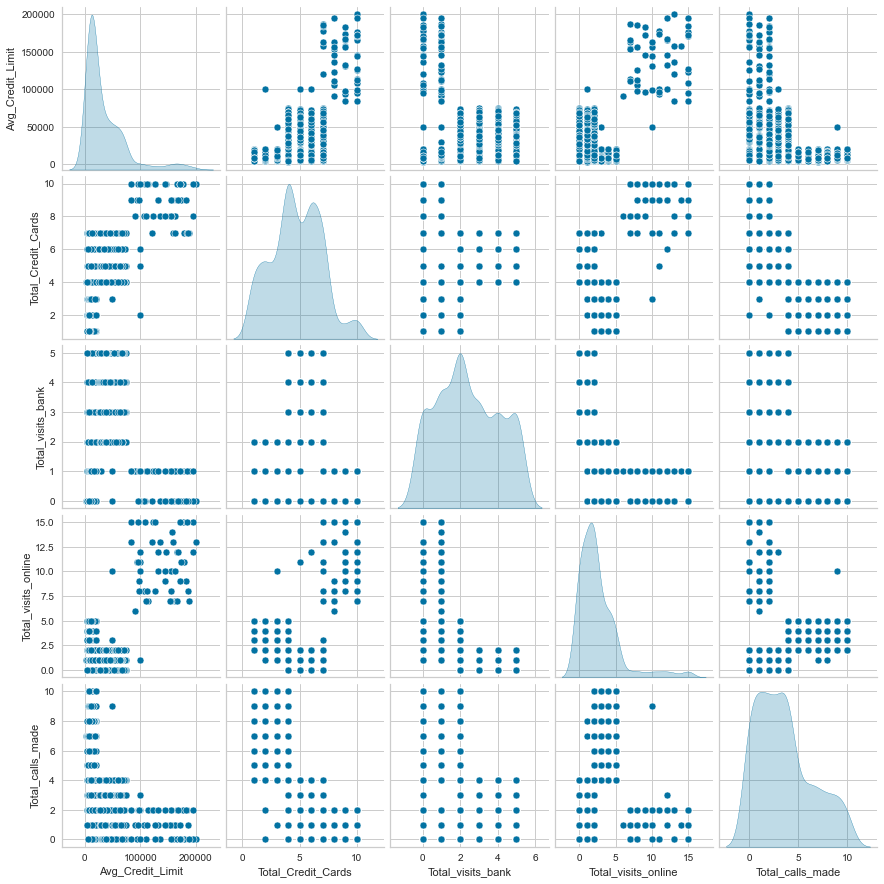

<IPython.core.display.Javascript object>

In [25]:
sns.pairplot(data=df, diag_kind="kde")
plt.show()

- KDEs give an idea of the distribution of the data points, and the possible clusters that might be needed.
- It appears like there might be more than 3 clusters for this dataset based off of the kde.

### Data Preprocessing

- Since there are no missing values, no imputation will be done.
- Any outliers present in the data set will also not be treated since they could constitute their own cluster.

In [26]:
# scaling the dataset before clustering
scaler = StandardScaler()
subset = df.copy()
subset_scaled = scaler.fit_transform(subset)

<IPython.core.display.Javascript object>

In [27]:
# creating a dataframe of the scaled columns
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

subset_scaled_df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


<IPython.core.display.Javascript object>

## K-Means Clustering

Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.9908683849620168
Number of Clusters: 6 	Average Distortion: 0.9429753673519395
Number of Clusters: 7 	Average Distortion: 0.9095661498049182
Number of Clusters: 8 	Average Distortion: 0.889453862381997
Number of Clusters: 9 	Average Distortion: 0.8682270550306045


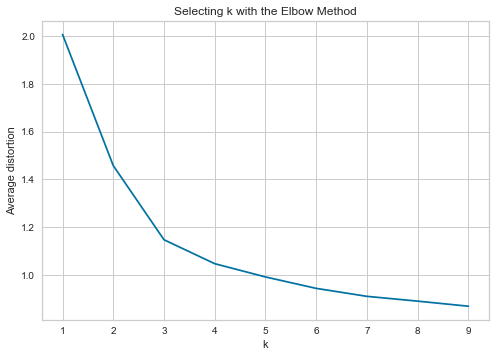

<IPython.core.display.Javascript object>

In [28]:
clusters = range(1, 10)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
plt.show()

- The values for K seem to be 3 or 4. Further analysis will help determine the appropriate value for clustering.
- **Silhoute scores** should help in teasing out the appropriate K value 

For 2_clusters, the silhouette score is 0.41842496663215445)
For 3_clusters, the silhouette score is 0.5157182558881063)
For 4_clusters, the silhouette score is 0.3556670619372605)
For 5_clusters, the silhouette score is 0.2717470361089752)
For 6_clusters, the silhouette score is 0.25583657571102003)
For 7_clusters, the silhouette score is 0.2494360582619592)
For 8_clusters, the silhouette score is 0.22788000313398277)
For 9_clusters, the silhouette score is 0.21972879421883068)


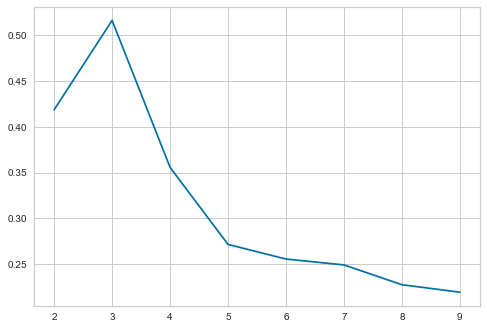

<IPython.core.display.Javascript object>

In [29]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For {}_clusters, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.show()

- As suspected earlier, 3 has the highest silhoute score, and is, therefore, a good number to cluster with.
- Once can run further analysis with **silhoute visualization** to check whether the understanding of the previous results is appropriate.

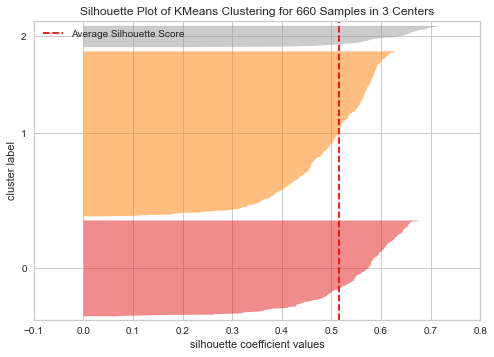

<IPython.core.display.Javascript object>

In [30]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

In [31]:
# Now the above visualization gets compared to that of 4 clusters.

<IPython.core.display.Javascript object>

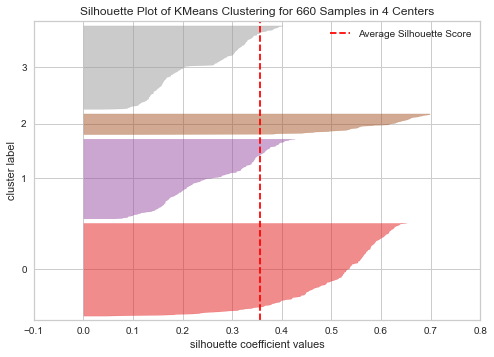

<IPython.core.display.Javascript object>

In [32]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

- 4 cluster do not seem to work as well as 3 cluster, hence,3 clusters will be used. The decision is based on how the average silhoute score line disects the plots.

In [33]:
%%time
# let's take 3 as number of clusters

kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(subset_scaled_df)

Wall time: 31.2 ms


KMeans(n_clusters=3, random_state=1)

<IPython.core.display.Javascript object>

In [34]:
# adding kmeans cluster labels to the original and scaled dataframes

df["K_means_segments"] = kmeans.labels_
subset_scaled_df["K_means_segments"] = kmeans.labels_
subset_scaled_df.sample(5)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments
476,0.942250,0.597334,1.592670,-0.88838,0.145528,1
333,-0.520633,0.135694,0.979390,-0.20660,-0.553005,1
566,0.091118,0.597334,1.592670,-0.88838,-0.902271,1
21,-0.494036,-1.249225,-1.473731,0.13429,1.193326,0
306,-0.414242,0.597334,0.366110,-0.88838,-1.251537,1


<IPython.core.display.Javascript object>

### Cluster Profiling_KM

In [35]:
cluster_profilek = df.groupby("K_means_segments").mean()

cluster_profilek["K_count_in_cluster"] = (
    df.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [36]:
# let's display cluster profiles
cluster_profilek.style.highlight_max(color="yellow", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_count_in_cluster
K_means_segments,,,,,,
0,12174.107143,2.410714,0.933036,3.553571,6.870536,224
1,33782.383420,5.515544,3.489637,0.981865,2.000000,386
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


<IPython.core.display.Javascript object>

- As it was mentioned earlier, people with more credit cards have (or should have) a higher credit limit. This could be an indication of high spenders. The bank could provide from adding more attention to such customers. 
- One also notices that these customers visit the bank less times. They interact with bank more online. Therefore, adding more online features or online presence could increase revenue to the bank.

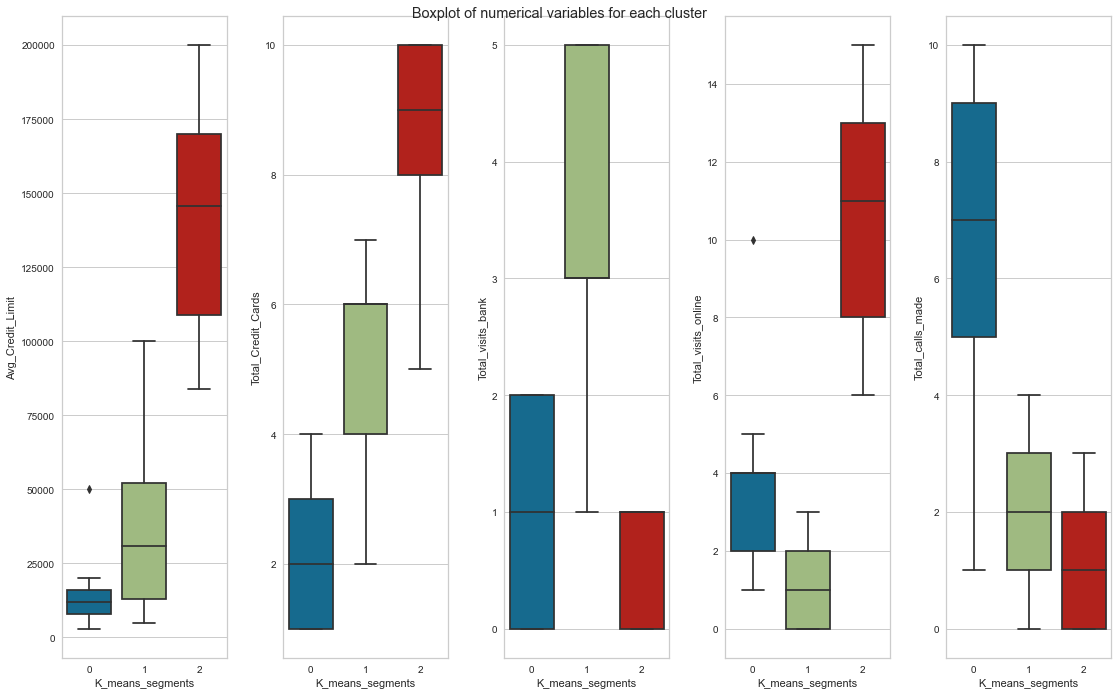

<IPython.core.display.Javascript object>

In [37]:
columns = df.select_dtypes(include=np.number).columns.tolist()

fig, axes = plt.subplots(1, 5, figsize=(16, 10))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[columns[counter]], x=df["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

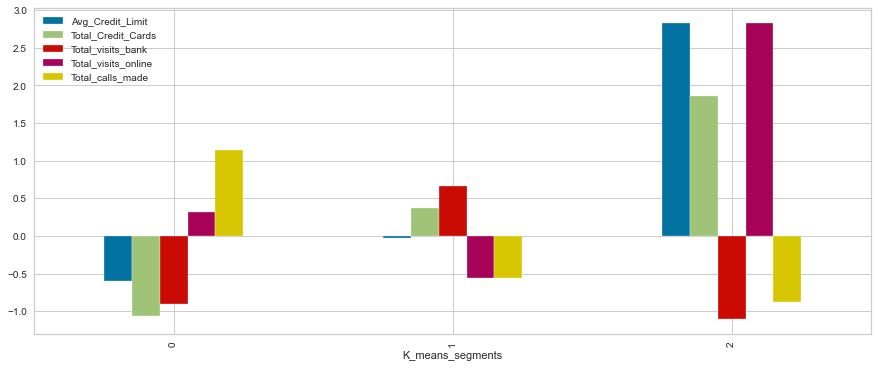

<IPython.core.display.Javascript object>

In [38]:
subset_scaled_df.groupby("K_means_segments").mean().plot.bar(figsize=(15, 6))

- These visualizations serve to confirm prior observations. For instance, one can notice that in cluster 2, they have higher credit limits and they visit the bank more online.
- Customers in cluster 0 could also be targeted to increase their engagement with the bank. They have the lower credit limit, lower credit card numbers, and lower total visits to the bank. Maybe these are customers that are further from the bank. The bank should reach out more to them via calls because it seems they prefer phone calls. Additionally, this could be an indication that these are older customers. Therefore, the bank should prepare packages that will be appealing to this clientele. 

## Hierarchical Clustering

In [39]:
# to compute distances
from scipy.spatial.distance import pdist

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet


<IPython.core.display.Javascript object>

In [40]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.8981791108157512.
Cophenetic correlation for Euclidean distance and complete linkage is 0.884420725860894.
Cophenetic correlation for Euclidean distance and average linkage is 0.9102691112621796.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.9069999252384202.
Cophenetic correlation for Chebyshev distance and single linkage is 0.8142004375043415.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8565360723350399.
Cophenetic correlation for Chebyshev distance and average linkage is 0.9092248615295281.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.9046661477870559.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.8650806042953478.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6100510675083303.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8419295288198599.
Cophenetic cor

<IPython.core.display.Javascript object>

- To synthesis the output above the following code can provide the best distance metric- linkage combination.

In [41]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9102691112621796, which is obtained with Euclidean distance and average linkage.


<IPython.core.display.Javascript object>

- We can confirm that this is the appropriate combination by checking the correlations using Euclidean distance.

In [42]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.8981791108157512.
Cophenetic correlation for complete linkage is 0.884420725860894.
Cophenetic correlation for average linkage is 0.9102691112621796.
Cophenetic correlation for centroid linkage is 0.906845257340526.
Cophenetic correlation for ward linkage is 0.7566252666432097.
Cophenetic correlation for weighted linkage is 0.9069999252384202.


<IPython.core.display.Javascript object>

- One can notice that the centroid, weighted, and single linkages also have high cophenetic correlation scores.

#### Visualizing the output above and trying to determine number of clusters.

Wall time: 3.86 s


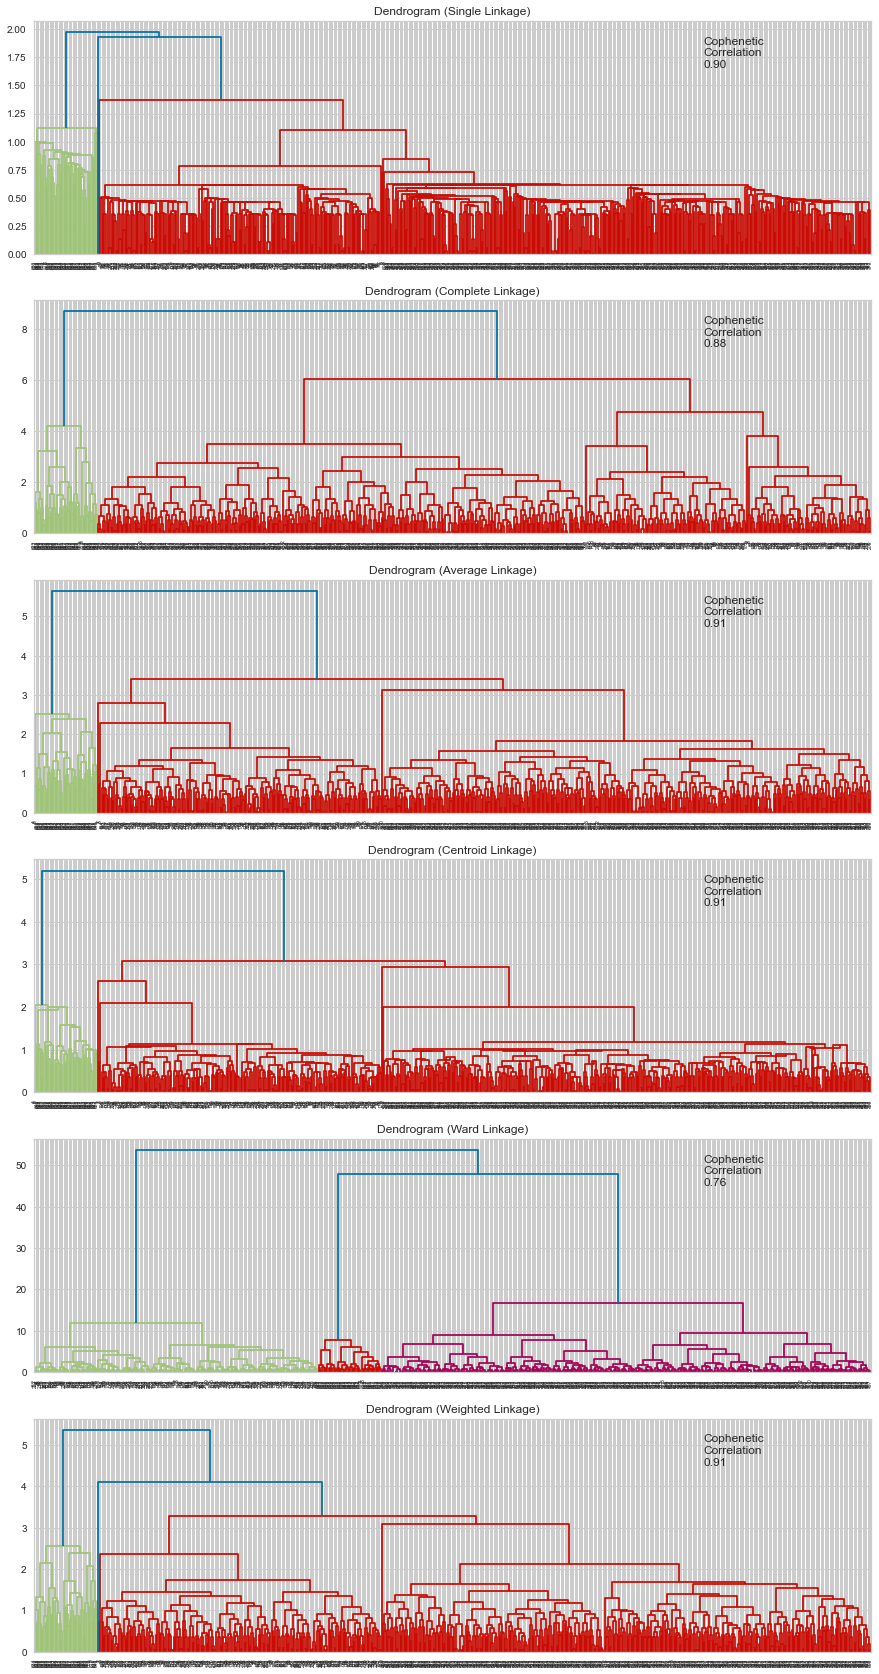

<IPython.core.display.Javascript object>

In [43]:
%%time
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

- Close correlation scores and amount of data make it challenging to decide on the appropriate number of clusters, but since average linkage has the highest cophenet score, it will be used for analysis.
- Additionally, it appears that for dendrograms with the highest cophenetic correlations 5-10 clusters is a possible cut-off point before the data becomes too confusing for analysis. 
- For relatively finer-grained clusters, 10 clusters will be used for analysis, but at the end of the analysis, comparison will be made to hierarchical clusters with only 3 clusters.

In [44]:
%%time
HCmodel = AgglomerativeClustering(n_clusters=10, affinity="euclidean", linkage="average")
HCmodel.fit(subset_scaled_df)

Wall time: 18 ms


AgglomerativeClustering(linkage='average', n_clusters=10)

<IPython.core.display.Javascript object>

In [45]:
subset_scaled_df["HC_Clusters"] = HCmodel.labels_
df["HC_Clusters"] = HCmodel.labels_

subset_scaled_df.sample(5)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,HC_Clusters
597,0.091118,1.058973,1.592670,-0.20660,-0.902271,1,0
49,-0.547231,-0.787585,-0.247170,-0.20660,0.844060,0,1
218,-0.414242,-0.787585,-0.860451,0.81607,1.193326,0,1
357,-0.733417,-0.325946,0.979390,-0.20660,-0.553005,1,0
66,-0.414242,-1.249225,-1.473731,0.13429,0.844060,0,1


<IPython.core.display.Javascript object>

### Cluster Profiling_HC

In [46]:
cluster_profile = df.groupby("HC_Clusters").mean()
cluster_profile["Count_in_cluster"] = (
    df.groupby("HC_Clusters")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [47]:
# CHecking the number of credit cards in each cluster.
for cl in df["HC_Clusters"].unique():
    print("In cluster {}, the following number of cards are owned:".format(cl))
    print(df[df["HC_Clusters"] == cl]["Total_Credit_Cards"].unique())
    print()

In cluster 7, the following number of cards are owned:
[2]

In cluster 9, the following number of cards are owned:
[3]

In cluster 0, the following number of cards are owned:
[7 5 4 6]

In cluster 5, the following number of cards are owned:
[6 5]

In cluster 1, the following number of cards are owned:
[3 4 1 2]

In cluster 8, the following number of cards are owned:
[3 2]

In cluster 3, the following number of cards are owned:
[ 9 10  8  7]

In cluster 4, the following number of cards are owned:
[ 9 10  8]

In cluster 6, the following number of cards are owned:
[ 8  9 10  7]

In cluster 2, the following number of cards are owned:
[ 8  7 10  9]



<IPython.core.display.Javascript object>

- The clusters appear to be well distributed. There doesn't appear to be any cluster that is prominent.

In [48]:
# lets display cluster profile
cluster_profile.style.highlight_max(color="yellow", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,Count_in_cluster
HC_Clusters,,,,,,,
0,33610.389610,5.524675,3.496104,0.981818,2.005195,1,385
1,12022.624434,2.407240,0.945701,3.542986,6.909502,0,221
2,119000.000000,8.625000,0.375000,14.250000,0.875000,2,8
3,181250.000000,9.250000,0.625000,14.250000,0.875000,2,8
4,102333.333333,9.333333,0.833333,8.833333,1.083333,2,12
5,100000.000000,5.500000,0.000000,11.500000,2.500000,2,2
6,161100.000000,8.550000,0.600000,9.400000,1.100000,2,20
7,100000.000000,2.000000,1.000000,1.000000,0.000000,1,1
8,10000.000000,2.500000,0.000000,1.500000,1.500000,0,2


<IPython.core.display.Javascript object>

- Customers with the higher credit limits visit the bank online the most and visit the bank physically fewer times.
- Customers with higher credit limits have more credit cards.
- As was observed earlier, customers with the lower credit limit made more calls to the bank. If this is an indication of them not being able to navigate to online bank resources, other more accessible options should be made available to them, and ultimately increase the bank's revenue. For instance, the bank can organize pop-ups in areas with high foot traffic to try and get more customers.

IndexError: list index out of range

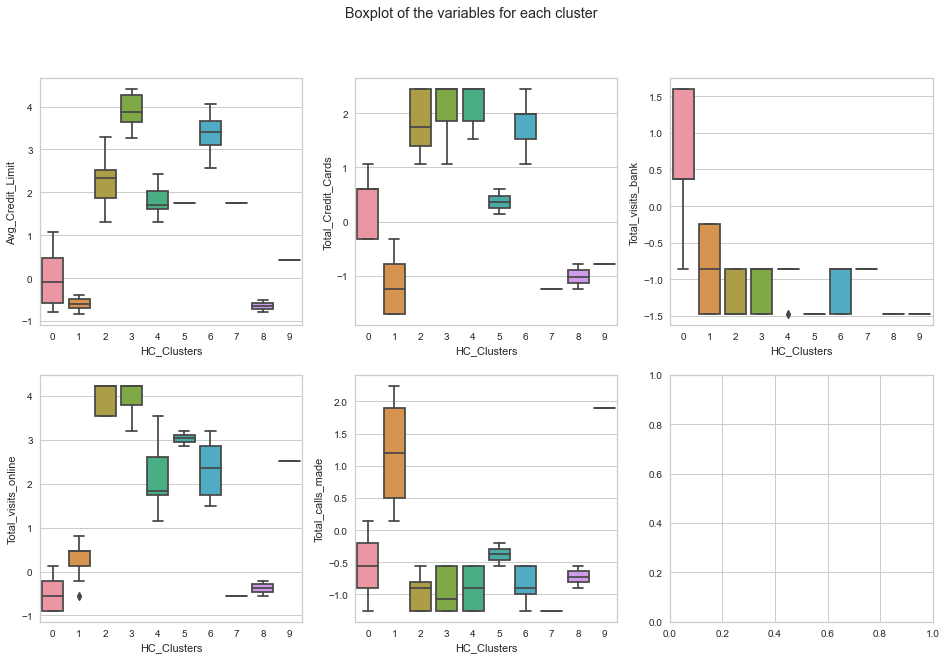

<IPython.core.display.Javascript object>

In [49]:
columns.remove("K_means_segments")
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle("Boxplot of the variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii][0],
        y=subset_scaled_df[columns[counter]],
        x=subset_scaled_df["HC_Clusters"],
    )
    counter = counter + 1
    sns.boxplot(
        ax=axes[ii][1],
        y=subset_scaled_df[columns[counter]],
        x=subset_scaled_df["HC_Clusters"],
    )
    counter = counter + 1
    sns.boxplot(
        ax=axes[ii][2],
        y=subset_scaled_df[columns[counter]],
        x=subset_scaled_df["HC_Clusters"],
    )
    counter = counter + 1


fig.tight_layout(pad=2.0)


- One can notice some overlap withing the clusters, but overall the variability is evident.

#### Hierarchical Clustering with 3 clusters.

In [50]:
HCmodel2 = AgglomerativeClustering(
    n_clusters=3, affinity="euclidean", linkage="average"
)
HCmodel2.fit(subset_scaled_df)

AgglomerativeClustering(linkage='average', n_clusters=3)

<IPython.core.display.Javascript object>

In [51]:
subset_scaled_df["HC_Clusters2"] = HCmodel2.labels_
df["HC_Clusters2"] = HCmodel2.labels_


<IPython.core.display.Javascript object>

In [52]:
cluster_profile2 = df.groupby("HC_Clusters2").mean()
cluster_profile2["Count_in_cluster"] = (
    df.groupby("HC_Clusters2")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [53]:
# CHecking the number of credit cards in each cluster.
for cl in df["HC_Clusters2"].unique():
    print("In cluster {}, the following number of cards are owned:".format(cl))
    print(df[df["HC_Clusters2"] == cl]["Total_Credit_Cards"].unique())
    print()

In cluster 0, the following number of cards are owned:
[2 3]

In cluster 1, the following number of cards are owned:
[7 5 3 4 1 2 6]

In cluster 2, the following number of cards are owned:
[ 6  5  9  8 10  7]



<IPython.core.display.Javascript object>

In [54]:
# lets display cluster profile
cluster_profile2.style.highlight_max(color="yellow", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,HC_Clusters,Count_in_cluster
HC_Clusters2,,,,,,,,
0,42500.000000,2.500000,0.250000,3.500000,3.000000,0.250000,8.000000,4
1,25737.623762,4.387789,2.566007,1.915842,3.793729,0.635314,0.364686,606
2,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000,4.360000,50


<IPython.core.display.Javascript object>

### Comparing the clustering techniques

- As one would expect, hierarchical clustering was noticeably a little bit slower especially when plotting the dendrograms. However, it should be noted that when fitting the models, K_means clustering had the slower execution time.
- Additionally, since ultimately there wasn't a score to help determine the number of hierarchical clusters,the cluster profiles were different since both model used different n_clusters. Nevertheless, in the grad scheme of things, mode tecchniques revealed similar things.
- Understandably, when the models had the same n_clusters, their performance was very similar. See dataframes below.
- K-means Clustering was able to provide more distinct clusters.

In [55]:
# K-Means cluster profiles
cluster_profilek.style.highlight_max(color="yellow", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_count_in_cluster
K_means_segments,,,,,,
0,12174.107143,2.410714,0.933036,3.553571,6.870536,224
1,33782.383420,5.515544,3.489637,0.981865,2.000000,386
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


<IPython.core.display.Javascript object>

In [56]:
# Hierarchical cluster profile
cluster_profile2.style.highlight_max(color="yellow", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,HC_Clusters,Count_in_cluster
HC_Clusters2,,,,,,,,
0,42500.000000,2.500000,0.250000,3.500000,3.000000,0.250000,8.000000,4
1,25737.623762,4.387789,2.566007,1.915842,3.793729,0.635314,0.364686,606
2,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000,4.360000,50


<IPython.core.display.Javascript object>

## Insights and Recommendations

- The insights made up to this point still hold true.
- Depending on how much funding is available for campaigns, the bank can chose to go with either few or more clusters. 
- In the case that the resources and manpower can not be stretched to reach even more homogenous groups, like in the case of working with 3 clusters, targeted campaigns can be done to the clusters.
- For instance, cluster 2 appears to be customers with higher purchasing power. The bank can entice them with even more credit card deals to increase their dealings with the bank.
- Cluster 2 customers also seem to be comfortable using the internet. The bank can increase their online banking presence through ads, and partnerships with popular websites to ensure that their cards are used in those websites.
- Cluster 1 customers have the lower credit limits. They also do not have many credit cards. It appears that they frequent the bank. This is an opportunity for the bank to upsell their products and services in person. Good sale representatives should capitalize on this opportunity and convert more bank visitors. This will ensure increased revenue to the bank.
- Cluster 0 customers seem to fall in the middle of the park. Statistically, the middle of the park is usually the majority. The bank should therefore ensure that their needs are always met, and at the same time roll out targeted campaigns to increase their spending with the bank.